## Import necessary libraries

In [1]:
%reset -f
import pandas as pd
import pickle
import numpy
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
# !pip install imblearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

c:\UNI\Jupyter\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
environment_variables = dir()

## Definition of model related constants

In [3]:
# Input parameters
INPUT_TRAINING_FILE =  "../data/original/training_dataset.csv"
INPUT_EVALUATION_FILE = "../data/original/evaluation_dataset.csv"

# Output parameters
METHOD_NAME = "xgboost"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 5
HYPER_PARAMETER_OPTIMIZATION_BETA = 2

# Cross validation parameters
CROSS_VALIDATION_CV = 5

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

# defining custom fbeta scores.
def custom_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

metrics =  ['logloss','rmse']

### Minor preprocessing

In [4]:

training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

## Define training pipeline

In [5]:
# Creating XGB clasifier with internal pipeline
classifier = xgb.XGBClassifier(eval_metric=make_scorer(custom_scorer)
                            ,seed=RANDOM_SEED)

# Stratified Cross Validation, smote, logistic regression, feature selection with SeleckKBest,
# hyperparameter optimization with randomized gridsearch
smote = SMOTE(sampling_strategy='minority', random_state=20)
# ros = RandomOverSampler()
# Assumption: data has a Gaussian distribution. Therfore use standardscaler and logistic regression.(Might be wrong, but looks better tha minmaxscaler)
scaler = StandardScaler() # is our data already normalised? (Do not think so).

feature_selection = SelectKBest(f_classif)
pca = PCA() #performs better with PCA

# feature selection before smote. Will smote in pipeline be applied to X_test when using predict? Don't want to balance test data!!!
# Does not look like smote is fited on test set, which is good.
# try and add pca
pipeline = imbpipeline(steps = [('selection', feature_selection),
                                ('pca', pca),
                                ('scaler', scaler), 
                                ('smote', smote),
                                # ('ros',ros),
                                ('clasification', classifier)])

# Setting tunable XBG parameters
parameters = {
                 "clasification__learning_rate": [  0.3],
                   "clasification__n_estimators": range(15,45,10)
                  ,'clasification__max_leaves' : [2,4,6,8,12,24]
                  , "clasification__max_depth": [6] 
                  , "selection__k": list(range(30, 90, 10))
                # , "ros__sampling_strategy": [0.05,0.1,0.2,0.3,0.4]
                  , "selection__score_func": [chi2,f_classif]
                  , "pca__n_components": [20,30,95]
                # ,'smote__k_neighbors': [5,10,15]
              }
# Best parameters.
parameters = {
                 "clasification__learning_rate": [  0.3],
                   "clasification__n_estimators": [15]
                  ,'clasification__max_leaves' : [25]
                  , "clasification__max_depth": [6] 
                  , "selection__k": [30]
                  , "selection__score_func": [f_classif]
                  , "pca__n_components": [22]
                ,'smote__k_neighbors': [5]
              }

In [6]:
# Getting the default hyper parameters of XGBoost
pipeline

Pipeline(steps=[('selection', SelectKBest()), ('pca', PCA()),
                ('scaler', StandardScaler()),
                ('smote', SMOTE(random_state=20, sampling_strategy='minority')),
                ('clasification',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               eval_metric=make_scorer(custom_scorer),
                               gamma=None,...
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
              

In [7]:
# K-fold parameters
cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=RANDOM_SEED)

grid_estimator = GridSearchCV(pipeline
                            , parameters
                            , scoring=make_scorer(custom_scorer)
                            , cv=cv
                            , verbose = 3
                            )


### Side usefull methods

In [8]:
def grid_search_results(grid, params1, params2, name1, name2):
    mean_score = grid.cv_results_['mean_test_score']
    std_score = grid.cv_results_['std_test_score']
    parameters = grid.cv_results_['params']

    # All of the results
    for mean_val, std_val, par_val in zip(mean_score, std_score, parameters):
        print(f" Mean {mean_score}, Std: {std_score}, parameters {parameters}")

## Training

In [9]:
grid_estimator.fit(training_features, training_targets 
, clasification__eval_metric = metrics)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clasification__learning_rate=0.3, clasification__max_depth=6, clasification__max_leaves=25, clasification__n_estimators=15, pca__n_components=22, selection__k=30, selection__score_func=<function f_classif at 0x000002141606D310>, smote__k_neighbors=5;, score=0.600 total time=   0.5s
[CV 2/5] END clasification__learning_rate=0.3, clasification__max_depth=6, clasification__max_leaves=25, clasification__n_estimators=15, pca__n_components=22, selection__k=30, selection__score_func=<function f_classif at 0x000002141606D310>, smote__k_neighbors=5;, score=0.399 total time=   0.4s
[CV 3/5] END clasification__learning_rate=0.3, clasification__max_depth=6, clasification__max_leaves=25, clasification__n_estimators=15, pca__n_components=22, selection__k=30, selection__score_func=<function f_classif at 0x000002141606D310>, smote__k_neighbors=5;, score=0.420 total time=   0.4s
[CV 4/5] END clasification__learning_rate=0.3, clasif

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('selection', SelectKBest()),
                                       ('pca', PCA()),
                                       ('scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(random_state=20,
                                              sampling_strategy='minority')),
                                       ('clasification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytr...
                                                      validate_parameters=None,
                                      

## Best score and model parameters

In [10]:
print("Best model: F-Beta. Score = %f, with parameters %s" % (grid_estimator.best_score_, grid_estimator.best_params_))

Best model: F-Beta. Score = 0.477276, with parameters {'clasification__learning_rate': 0.3, 'clasification__max_depth': 6, 'clasification__max_leaves': 25, 'clasification__n_estimators': 15, 'pca__n_components': 22, 'selection__k': 30, 'selection__score_func': <function f_classif at 0x000002141606D310>, 'smote__k_neighbors': 5}


### Plotting a tree model   

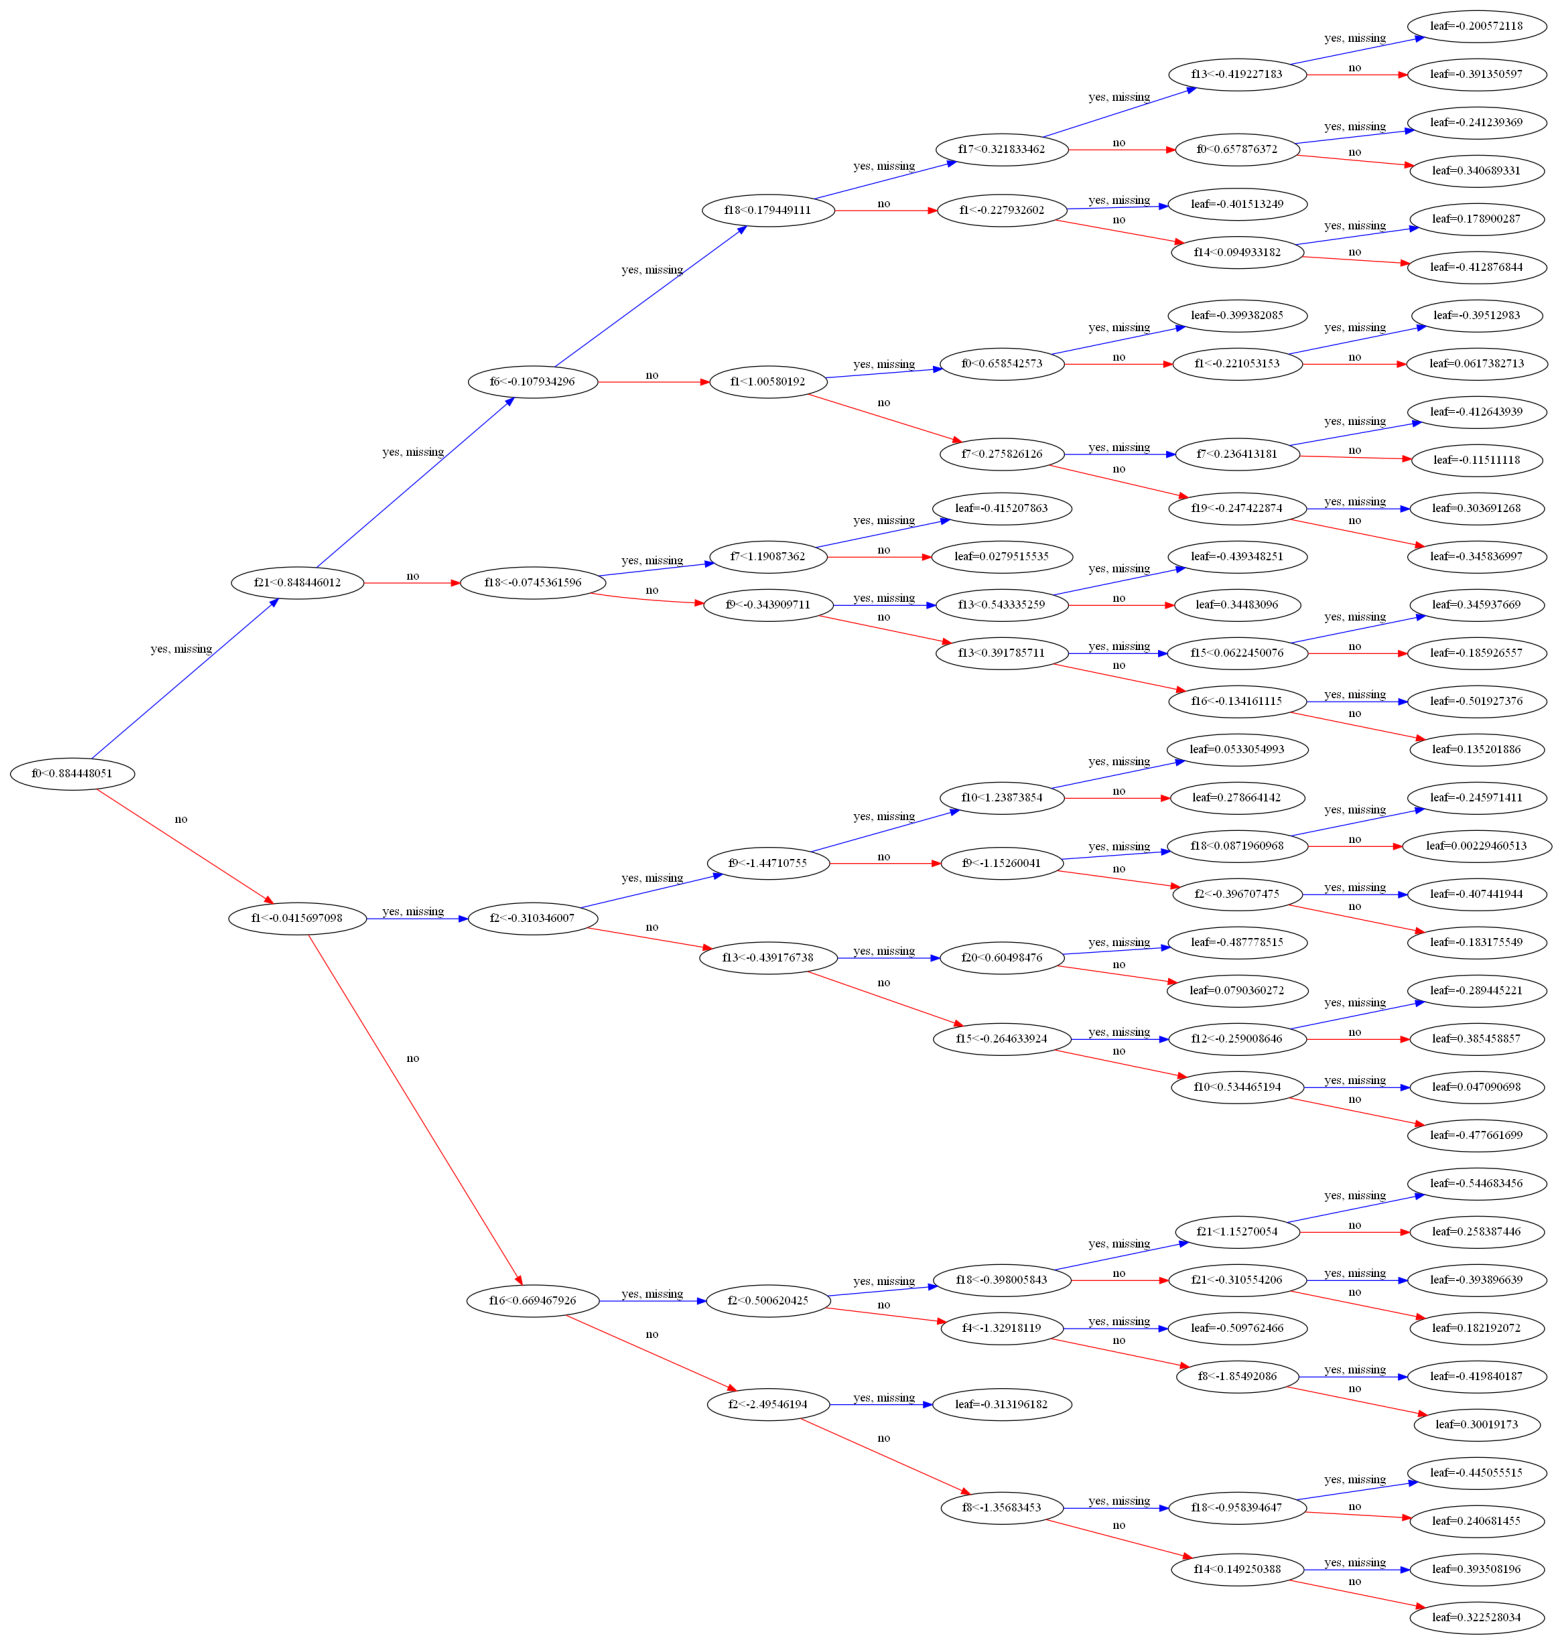

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=make_scorer(custom_scorer), gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6, max_leaves=25,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=15, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1, ...)

In [11]:
from xgboost import plot_tree
import os
os.environ['PATH'] += ';C:\\Program Files\\Graphviz\\bin'
import graphviz

model = grid_estimator.best_estimator_['clasification']
fig, ax = plt.subplots(figsize=(30, 30))

plot_tree(model, num_trees=2, rankdir='LR',  ax=ax)
plt.show()
model

## Value metrics

In [12]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, training_features, training_targets, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))

evaluation_estimates = grid_estimator.predict(evaluation_features)
scores = cross_val_score(pipeline, evaluation_targets, evaluation_estimates, cv=cv, scoring = 'roc_auc')
print("roc_auc of evaluation %f (%f)" % (scores.mean(), scores.std()))

[23:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:38:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [13]:
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

# Use all training data to calculate confusion matrix for training data
training_estimates = grid_estimator.predict(training_features)
training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)
training_classification_report = classification_report(training_targets, training_estimates, output_dict=True, target_names=LABELS)
training_f_beta_score = fbeta_score(training_targets, training_estimates, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

# Use model to estimate manually labeled evaluation Tweets
evaluation_estimates = grid_estimator.predict(evaluation_features)
evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)
evaluation_classification_report = classification_report(evaluation_targets, evaluation_estimates, output_dict=True, target_names=LABELS)
evaluation_f_beta_score = fbeta_score(evaluation_targets, evaluation_estimates, beta=HYPER_PARAMETER_OPTIMIZATION_BETA)

# Store best parameters
best_parameters = grid_estimator.best_params_
print(best_parameters)

{'clasification__learning_rate': 0.3, 'clasification__max_depth': 6, 'clasification__max_leaves': 25, 'clasification__n_estimators': 15, 'pca__n_components': 22, 'selection__k': 30, 'selection__score_func': <function f_classif at 0x000002141606D310>, 'smote__k_neighbors': 5}


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer
print("Training evaluation")
y_pred_train = grid_estimator.predict(training_features) #prediction on our train 
print(classification_report(training_targets, y_pred_train))
train_conf_matrix = confusion_matrix(training_targets, y_pred_train)

print("Validation/evaluation")
y_pred_test = grid_estimator.predict(evaluation_features) # prediction on our test set
print(classification_report(evaluation_targets, y_pred_test))
test_conf_matrix = confusion_matrix(evaluation_targets, y_pred_test)

print("Evaluation f_beta2")
display(evaluation_f_beta_score)
print("Training f_beta2")
display(training_f_beta_score)


print(f"training_accuracy {training_accuracy}")

print(f"evaluation_accuracy {evaluation_accuracy}")

Training evaluation
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      5279
           1       0.41      1.00      0.58       176

    accuracy                           0.95      5455
   macro avg       0.70      0.98      0.78      5455
weighted avg       0.98      0.95      0.96      5455

Validation/evaluation
              precision    recall  f1-score   support

           0       0.99      0.91      0.94      1320
           1       0.19      0.66      0.29        44

    accuracy                           0.90      1364
   macro avg       0.59      0.78      0.62      1364
weighted avg       0.96      0.90      0.92      1364

Evaluation f_beta2


0.43939393939393934

Training f_beta2


0.7753303964757708

training_accuracy 0.9758476984277324
evaluation_accuracy 0.7821969696969697


### Confusion matrix

In [15]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_log_error

def RMSLE(y_true, y_pred):
    return numpy.sqrt(mean_squared_log_error(y_true, y_pred))

from sklearn.metrics import confusion_matrix
def full_conf_mat(y_test, y_pred, data_title="Confusion Matrix of Training data"):
    
    print('-- Model Specs --')
    print(f"  - Test Accuracy {accuracy_score(y_test, y_pred)} % ")
    print(f"  - RMSLE {RMSLE(y_test,y_pred)}  ")

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)
    import seaborn as sns
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title(f'{data_title}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
print("Training_conf")
confusion_matrix(training_targets, training_estimates)

print("evaluation_conf")
confusion_matrix(evaluation_targets, evaluation_estimates)


Training_conf
evaluation_conf


array([[1195,  125],
       [  15,   29]], dtype=int64)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('selection', SelectKBest()),
                                       ('pca', PCA()),
                                       ('scaler', StandardScaler()),
                                       ('smote',
                                        SMOTE(random_state=20,
                                              sampling_strategy='minority')),
                                       ('clasification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytr...
                                                      validate_parameters=None,
                                      

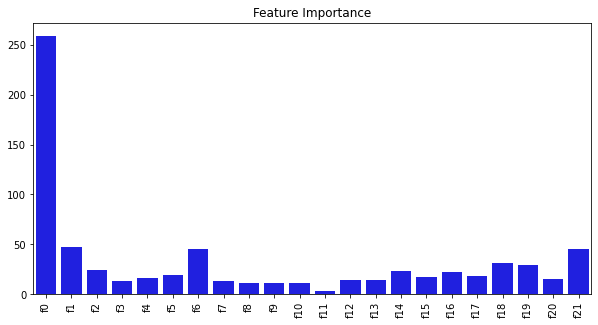

In [16]:
def plot_xgb(params,scores,epo):
    for m in params:
        test_ = scores['validation_0'][m]
        train_ = scores['validation_1'][m]
        rang = range(0, epo)
        
        plt.plot(rang, test_, label="Val")
        plt.plot(rang, train_, label="Train")
        plt.title(m + " plot")
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
 
print(grid_estimator)

f, ax = plt.subplots(figsize=(10,5))

# Plot of features
keys  = evaluation_dataset.columns.to_list() 
yy = grid_estimator.best_estimator_.named_steps["clasification"].feature_importances_

feature_important  = grid_estimator.best_estimator_.named_steps["clasification"].get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
yy = list(feature_important.values())


plot = sns.barplot(x=keys, y=yy, color='blue')
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Saving trained model

In [17]:
with open(OUTPUT_MODEL, "wb") as handle:
    pickle.dump(grid_estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Saving metadata

In [18]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
# for line in results_string:
print(f'{results_string}')
print("Best model: Acc. Score = %f, with parameters %s" % (grid_estimator.best_score_, grid_estimator.best_params_))


# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)
    file.write(str("Best model: Acc. Score = %f, with parameters %s" % (grid_estimator.best_score_, grid_estimator.best_params_)))

CROSS_VALIDATION_CV: 5
HYPER_PARAMETER_OPTIMIZATION_BETA: 2
HYPER_PARAMETER_OPTIMIZATION_CV: 5
HYPER_PARAMETER_OPTIMIZATION_SCORING: accuracy
INPUT_EVALUATION_FILE: ../data/original/evaluation_dataset.csv
INPUT_TRAINING_FILE: ../data/original/training_dataset.csv
LABELS: ['Operational', 'Bankrupt']
METHOD_NAME: xgboost
OUTPUT_MODEL: ../data/models/xgboost_model_24_05_2022-23_38_22.pkl
OUTPUT_RESULTS: ../data/results/xgboost_model_24_05_2022-23_38_22.txt
RANDOM_SEED: 42
TIMESTAMP: 24_05_2022-23_38_22
best_parameters: {'clasification__learning_rate': 0.3, 'clasification__max_depth': 6, 'clasification__max_leaves': 25, 'clasification__n_estimators': 15, 'pca__n_components': 22, 'selection__k': 30, 'selection__score_func': <function f_classif at 0x000002141606D310>, 'smote__k_neighbors': 5}
evaluation_accuracy: 0.7821969696969697
evaluation_classification_report: {'Operational': {'precision': 0.987603305785124, 'recall': 0.9053030303030303, 'f1-score': 0.9446640316205535, 'support': 1320},